In [1]:
using HDF5
using PyPlot
using Statistics

In [2]:
U = h5open("v1_layer3/U_avg.h5", "r") do file
    read(file, "matrix")end

V = h5open("v1_layer3/V_avg.h5", "r") do file
    read(file, "matrix")end

M = h5open("v1_layer3/M_avg.h5", "r") do file
    read(file, "matrix")end

xgrid = h5open("v1_layer3/xgrid_matrix", "r") do file
        read(file, "matrix")end

ygrid = h5open("v1_layer3/ygrid_matrix", "r") do file
        read(file, "matrix")end

63×63×393 Array{Float32, 3}:
[:, :, 1] =
   16.0    16.0    16.0    16.0    16.0  …    16.0    16.0    16.0    16.0
   32.0    32.0    32.0    32.0    32.0       32.0    32.0    32.0    32.0
   48.0    48.0    48.0    48.0    48.0       48.0    48.0    48.0    48.0
   64.0    64.0    64.0    64.0    64.0       64.0    64.0    64.0    64.0
   80.0    80.0    80.0    80.0    80.0       80.0    80.0    80.0    80.0
   96.0    96.0    96.0    96.0    96.0  …    96.0    96.0    96.0    96.0
  112.0   112.0   112.0   112.0   112.0      112.0   112.0   112.0   112.0
  128.0   128.0   128.0   128.0   128.0      128.0   128.0   128.0   128.0
  144.0   144.0   144.0   144.0   144.0      144.0   144.0   144.0   144.0
  160.0   160.0   160.0   160.0   160.0      160.0   160.0   160.0   160.0
  176.0   176.0   176.0   176.0   176.0  …   176.0   176.0   176.0   176.0
  192.0   192.0   192.0   192.0   192.0      192.0   192.0   192.0   192.0
  208.0   208.0   208.0   208.0   208.0      208.0   208.0 

In [12]:
replace!(U, NaN => 0)
replace!(V, NaN => 0)

63×63×394 Array{Float32, 3}:
[:, :, 1] =
 0.0       0.0        0.0       0.0       …   0.0        0.0          0.0
 0.0       0.0        0.0       0.0           0.0        0.0          0.0
 0.0       0.0        0.0       0.0           0.0        0.0          0.0
 0.0       0.0        0.0       0.0           0.0        0.0          0.0
 0.0       0.0        0.0       0.0           0.0        0.0          0.0
 0.0       0.0        0.0       0.0       …   0.0        0.0          0.0
 0.0       0.0        0.0       0.0           0.0        0.0          0.0
 0.0       0.0        0.0       0.0           0.0        0.0          0.0
 0.0       0.0        0.0       0.0           0.0        0.0          0.0
 0.0       0.0        0.0       0.0           0.0        0.0          0.0
 0.0       0.0        0.0       0.0       …   0.0        0.0          0.0
 0.0       0.0        0.0       0.0           0.0        0.0          0.0
 0.0       0.0        0.0       0.0           0.0        0.0          0

# Original function modified into 2D.
from https://github.com/Marc-3d/multi_quickPIV/blob/main/src/postprocessing/postprocessing.jl

In [10]:
function PIVtrajectories_grid(U::Array{Float32, 3}, V::Array{Float32, 3}, T0::Int64, T1::Int64; 
                                subregion=( 1:-1, 1:-1 ), step=(1,1), scale=(1,1))
    # The staring points are in all points in the vector matrix. 
    # Automatticlly returns all points in vector field from subregion the tracking data.
    # step determine the distance between the starting points. 
    # scale can rescale the length of the arrows. PIV has the tendence to underestimate the movement velocity.

    # Length of the each axis of the vector field. 
    dims  = ( length( 1:size(U,1) ), length( 1:size(U,2) ) ) 

    # The user can limit the simulation to a certain subregion of the vector field. 
    sampling_region = [ length( subregion[i] ) == 0 ? (2:step[i]:dims[i]-1) : Base.StepRange( subregion[i].start, step[i], subregion[i].stop ) for i in 1:2 ];
    scale = (typeof(scale)<:Number) ? (scale,scale) : scale

    numT = T1 - T0;
    TrajectoriesY = zeros( Float32, numT, prod( length.(sampling_region) ) ) # Have to be changed if manuelly giving the starting coordenates.
    TrajectoriesX = zeros( Float32, numT, prod( length.(sampling_region) ) )

    pidx = 0; 
    for x in sampling_region[2], y in sampling_region[1] # Could customize the sampling region through manuelly giving the x and y coordinates. 

        pidx += 1; 

        # Placing a new particle inside the vector-field. This is done by 
        # randomly picking a random position withing the vector-field. 
        starting_pos = (y,x); 

        # Recording the starting position in the first timepoints in the trajectory tables for point $pidx. 
        TrajectoriesY[ 1, pidx ] = Float32( starting_pos[1] )
        TrajectoriesX[ 1, pidx ] = Float32( starting_pos[2] )

        # Sampling the translation at the current ( starting ) position
        dY = Float32( scale[1] * U[ starting_pos..., T0 ] )
        dX = Float32( scale[2] * V[ starting_pos..., T0 ] )
        
        # moving forward in time, from T0 to T1
        for t in 2:numT

            # New_pos = previous position + translation (dU,dV,dW); 
            updated_pos = ( TrajectoriesY[t-1, pidx], TrajectoriesX[t-1, pidx] ) .+ ( dY, dX ); 

            # Recording the updated position in the trajectory tables
            TrajectoriesY[t,pidx] = updated_pos[1]
            TrajectoriesX[t,pidx] = updated_pos[2]

            # Obtaining the integer index of the updated position
            int_updated_pos = round.( Int64, updated_pos ); 

            # If the (integer) updated position is out of the coordinates of the vector field, stop
            if any( int_updated_pos .< 1 ) || any( int_updated_pos .> dims ) 
                TrajectoriesY[ t:end, pidx ] .= TrajectoriesY[ t-1, pidx ]
                TrajectoriesX[ t:end, pidx ] .= TrajectoriesX[ t-1, pidx ]
                break
            end

            # Sampling the translation at the (integer) updated position
            dY = Float32( scale[1] * U[ int_updated_pos..., T0+t-1 ] )
            dX = Float32( scale[2] * V[ int_updated_pos..., T0+t-1 ] )
        end
    end

    return TrajectoriesY, TrajectoriesX
end

PIVtrajectories_grid (generic function with 1 method)

In [13]:
PIVtrajectories_grid(U, V, 100, 150)

(Float32[2.0 3.0 … 61.0 62.0; 2.9314337 3.9197855 … 60.079018 61.0; … ; 23.841679 18.77805 … 57.606934 53.145416; 23.841679 18.77805 … 57.606934 54.00926], Float32[2.0 2.0 … 62.0 62.0; 1.9554796 2.8981066 … 60.027077 59.0356; … ; 10.030341 8.217827 … 48.276554 52.87551; 10.030341 8.217827 … 48.276554 52.762077])

# Modification with given sampling regions

Problems: 

1. seems to have large rounding errors
2. The x and y positions are implemented with vector field matrix positions instead of the image pixel positions! Quite unconvient for application.
3. Use only the vector direction of the directed neighboured IA center. No averaging of neighbour fields.

In [37]:
function PIVtrajectories_grid_given_cor(U::Array{Float32, 3}, V::Array{Float32, 3}, T0::Int64, T1::Int64,
                                        x_cor::Vector{Int64}, y_cor::Vector{Int64}, scale=(1, 1))
    # The staring points are in all points in the vector matrix. 
    # Automatticlly returns all points in vector field from subregion the tracking data.
    # step determine the distance between the starting points. 
    # scale can rescale the length of the arrows. PIV has the tendence to underestimate the movement velocity.

    if length(x_cor) != length(y_cor)
        print("x and y positions should have the same lengths!")
        
    else

        # Length of the each axis of the vector field. 
        dims  = ( length( 1:size(U,1) ), length( 1:size(U,2) ) ) 
    
        numT = T1 - T0;
        TrajectoriesY = zeros( Float32, numT,  length(x_cor)) 
        TrajectoriesX = zeros( Float32, numT, length(x_cor) )
    
        for pidx in 1:length(x_cor) # Could customize the sampling region through manuelly giving the x and y coordinates. 

            x = x_cor[pidx]
            y = y_cor[pidx]
    
            # Placing a new particle inside the vector-field. This is done by 
            # randomly picking a random position withing the vector-field. 
            starting_pos = (y,x); 
    
            # Recording the starting position in the first timepoints in the trajectory tables for point $pidx. 
            TrajectoriesY[ 1, pidx ] = Float32( starting_pos[1] )
            TrajectoriesX[ 1, pidx ] = Float32( starting_pos[2] )
    
            # Sampling the translation at the current ( starting ) position
            dY = Float32( scale[1] * U[ starting_pos..., T0 ] )
            dX = Float32( scale[2] * V[ starting_pos..., T0 ] )
            
            # moving forward in time, from T0 to T1
            for t in 2:numT

                # New_pos = previous position + translation (dU,dV,dW); 
                updated_pos = ( TrajectoriesY[t-1, pidx], TrajectoriesX[t-1, pidx] ) .+ ( dY, dX )
    
                # Recording the updated position in the trajectory tables
                TrajectoriesY[t,pidx] = updated_pos[1]
                TrajectoriesX[t,pidx] = updated_pos[2]
    
                # Obtaining the integer index of the updated position
                int_updated_pos = round.(Int64, updated_pos)
    
                # If the (integer) updated position is out of the coordinates of the vector field, stop
                if any( int_updated_pos .< 1 ) || any( int_updated_pos .> dims ) 
                    TrajectoriesY[ t:end, pidx ] .= TrajectoriesY[ t-1, pidx ]
                    TrajectoriesX[ t:end, pidx ] .= TrajectoriesX[ t-1, pidx ]
                    break
                end
    
                # Sampling the translation at the (integer) updated position
                dY = Float32( scale[1] * U[ int_updated_pos..., T0+t-1 ] )
                dX = Float32( scale[2] * V[ int_updated_pos..., T0+t-1 ] )

            end
        end
    end

    return TrajectoriesY, TrajectoriesX
end

PIVtrajectories_grid_given_cor (generic function with 3 methods)

In [44]:
y_track, x_track = PIVtrajectories_grid_given_cor(U, V, 1, 300, [10, 20, 30], [10, 20, 30])

(Float32[10.0 20.0 30.0; 10.0 20.0 30.0; … ; 24.623943 41.540535 62.612473; 24.53849 41.540535 62.612473], Float32[10.0 20.0 30.0; 10.0 20.0 30.0; … ; 23.245617 23.49982 31.03274; 22.941647 22.592194 31.03274])

In [45]:
y_track

299×3 Matrix{Float32}:
 10.0     20.0     30.0
 10.0     20.0     30.0
 10.0     20.0     30.0
 10.0     20.0     30.0
 10.0     20.0     30.0
 10.0     20.0     30.0
 10.0     20.0     30.0
 10.0     20.0     30.0
 10.0     20.0     30.0
 10.0     20.0     30.0
 10.0     20.9217  30.0
 10.0     23.2101  30.0
 10.0     27.3861  30.0
  ⋮                
 24.6239  41.5405  60.1628
 24.6239  41.5405  60.4527
 24.6239  41.5405  60.7898
 24.6239  41.5405  61.4123
 24.6239  41.5405  62.0348
 24.6239  41.5405  62.1349
 24.6239  41.5405  62.6125
 24.6239  41.5405  62.6125
 24.6239  41.5405  62.6125
 24.6239  41.5405  62.6125
 24.6239  41.5405  62.6125
 24.5385  41.5405  62.6125

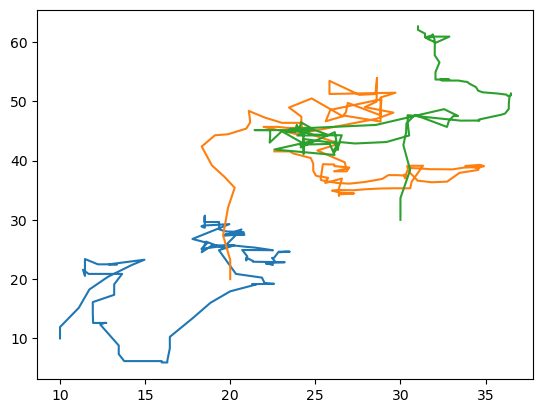

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001F26463EFB0>

In [48]:
PyPlot.plot(x_track[:, 1], y_track[:, 1])
PyPlot.plot(x_track[:, 2], y_track[:, 2])
PyPlot.plot(x_track[:, 3], y_track[:, 3])

Tracking starting pixel positions from experimental data: 
Manuelly noted stop tracking at t=271

p1: x = 249, y = 460, t=17
p76: x = 185, y = 546, t=22
p32: x = 108, y = 392, t = 31
p8: x = 519, y = 577, t=49
p33: x = 120, y = 437, t=51
p2: x=244, y=498, t=52
p84: x=11, y=298, t=59
p74: x=294, y=230, t=57
p41/42: x=69, y =507, t=64
p27: x = 182, y=54, t=67
p30: x=501, y=338, t=79